## Incremental learning with River

In [189]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from river import metrics
import sys
from util import *
from scipy.stats import mode
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler
from predict import binarize
import os

In [2]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [15]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [4]:
subset_indices =  [  191, 374,  328,  673]

### Recreate original dataset

In [5]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [6]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [7]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [111]:
random.seed(42)
np.random.seed(42)
test_size = 0.25

train_idx = np.concatenate([[i*36 + np.random.choice(36, size=int(36*(1-test_size)), replace=False)] for i in range(17)], axis=1)[0]
test_idx = np.array([j for j in range(data_all.shape[0]) if j not in train_idx])
print(train_idx[:10])
X_train_top_f = data_all[np.sort(train_idx)]
X_test_top_f = data_all[np.sort(test_idx)]

X_train_top_f = X_train_top_f[:, subset_indices]
X_test_top_f = X_test_top_f[:, subset_indices]

y_train = y_all[train_idx]
y_test  = y_all[test_idx]

X_test_top_f.shape, X_train_top_f.shape, y_test.shape, y_train.shape 

[35 13 26 30 16 31 21 12  8 17]


((153, 4), (459, 4), (153,), (459,))

In [36]:
np.where(y_train == 1)[0][0]

216

In [22]:
def plot_roc(true_y, y_prob, method_name):
    fpr, tpr, _ = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {method_name}')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
param_grid_bcc_log = {
    'C': [0.01, 0.1, 0.2, 0.5, 10]
} # rbf by default

### Method 0: Random sampling

In [96]:
# since the budget will be exhausted before even getting to 
def simulate_selection(budget, nbr_inst):
    global y_train
    normal_sample = []
    damage_sample = []
    # get the point at which damage starts
    while len(normal_sample) == 0 or len(damage_sample) == 0:
        start_damage = np.where(y_train == 1)[0][0]
        prop_dam = random.uniform(2*(9/17)-1, 1) # centered slightly above 0.5 since there are more damaged than undamaged
        ss1 = int((1-prop_dam)*budget)
        ss2 = int(prop_dam*budget)
        if (ss1 > start_damage) or ss2 > (nbr_inst - start_damage):
            continue
        normal_sample =  np.array(random.sample(range(0, start_damage), ss1)).astype(int)
        damage_sample =  np.array(random.sample(range(start_damage, nbr_inst), ss2)).astype(int)
        
    return np.hstack((normal_sample, damage_sample))

In [103]:
def random_sampling_experiment(seed = 42):
    global param_grid_bcc_log, X_train_top_f
    dict_rnd = {}
    nbr_train = X_train_top_f.shape[0]
    for i in np.arange(24, nbr_train, 1):
        # obtain training indices and subset training data accordingly
        train_indices =  simulate_selection(i, nbr_train) #np.hstack((np.arange(10), simulate_selection(i, nbr_train))) #random.sample(range(nbr_train), i)
        data_train_rnd = X_train_top_f[train_indices, :]
        labels_rnd = y_train[train_indices]

        # find the optimal model and fit it
        log_reg = LogisticRegression(C = 10) #GridSearchCV(LogisticRegression(), param_grid_bcc_log, scoring = 'accuracy', cv = 5) GridSearch cannot be used since many splits only contain one class
        log_reg.fit(data_train_rnd, labels_rnd)
        
        # inference and scoring
        y_pred = log_reg.predict(X_test_top_f)
        y_prob = log_reg.predict_proba(X_test_top_f)[:, 1]
        
        # append scores to dictionary
        dict_rnd[i] = [y_test, y_pred, y_prob]
    return dict_rnd

In [104]:
rnd_bcc_all_exp = []    
random.seed(12)
for i in range(30):
    rnd_bcc_all_exp.append(random_sampling_experiment(seed = i))

In [105]:
import json
exp_temp = []
for exp in rnd_bcc_all_exp:
    dict_tmp = {}
    for key in exp.keys():
        dict_tmp[int(key)] = [i.tolist() for i in exp[key]] # need to convert keys to int, not int32, in order to save
    exp_temp.append(dict_tmp)

with open('rnd_bcc_all_exp_log_nogrid.json', 'w') as file:
    json.dump(exp_temp, file)

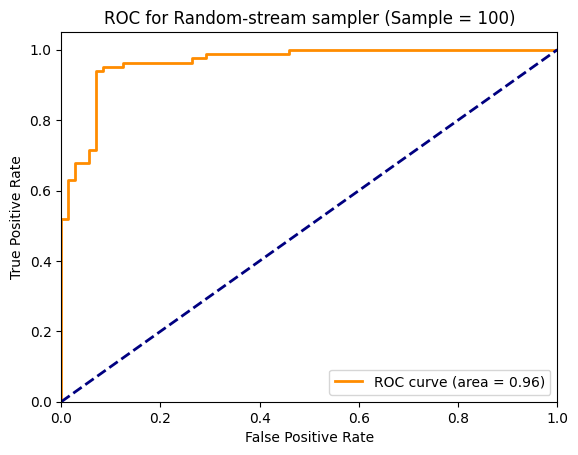

In [374]:
d_rnd = rnd_bcc_all_exp[0]
plot_roc(d_rnd[100][0], d_rnd[100][2], "Random-stream sampler (Sample = 100)")

[[63.8         8.2       ]
 [ 7.03333333 73.96666667]]


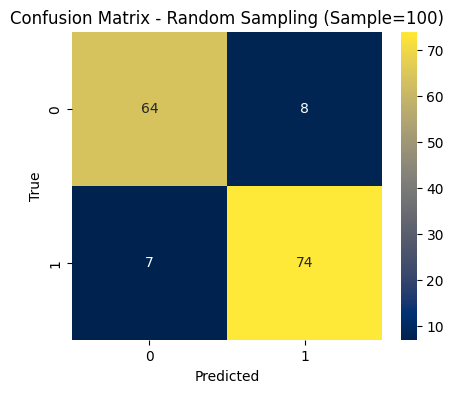

In [401]:
cms = [confusion_matrix(d_rnd[100][0], d_rnd[100][1]) for d_rnd in rnd_bcc_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(rnd_bcc_all_exp)
print(mean_conf_matrix)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Random Sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

(435,)
(435,)
(435,)
(435,)
(435,)


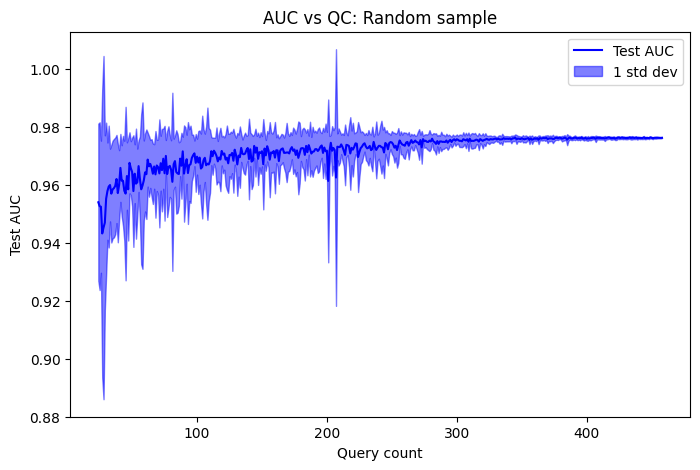

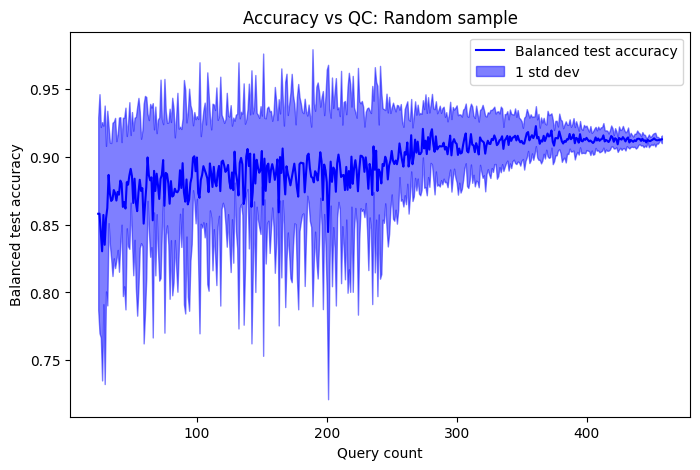

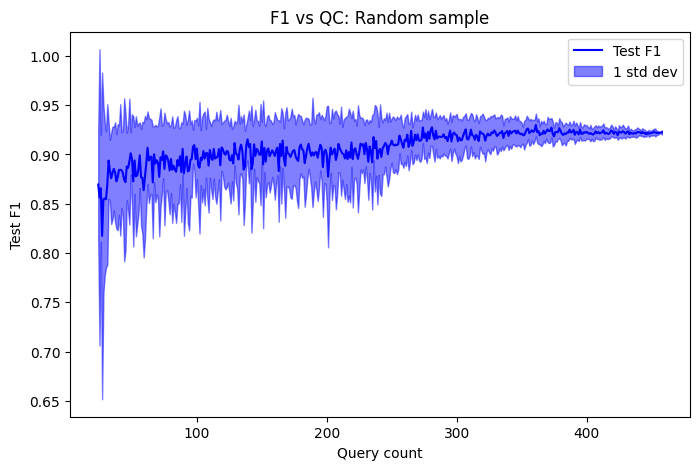

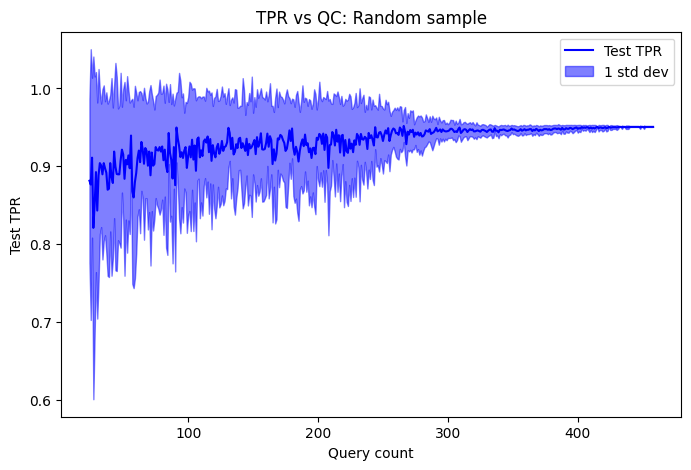

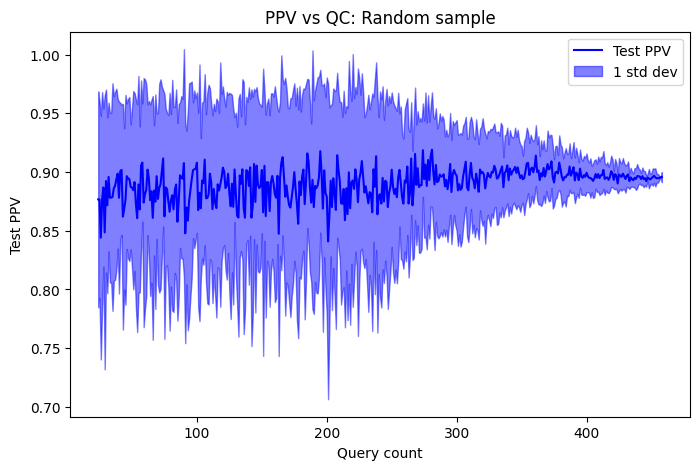

In [108]:
## f1 score 
f1_rnd = np.array(all_f1_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_f1_rnd = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_f1_rnd.shape)

## auc 
auc_rnd = np.array(all_auc(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_auc_rnd = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)
print(avg_auc_rnd.shape)

## accuracy
acc_rnd = np.array(all_accu_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_acc_rnd = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)
print(avg_acc_rnd.shape)

## precision
pre_rnd = np.array(all_precision_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_pre_rnd = np.mean(pre_rnd, axis = 0)
std_pre = np.std(pre_rnd, axis = 0)
print(avg_pre_rnd.shape)

## recall
rec_rnd = np.array(all_recall_score(range(24, X_train_top_f.shape[0]), rnd_bcc_all_exp))
avg_rec_rnd = np.mean(rec_rnd, axis = 0)
std_rec = np.std(rec_rnd, axis = 0)
print(avg_rec_rnd.shape)

fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_auc_rnd], [std_auc], "Test AUC", "AUC vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_acc_rnd], [std_acc], "Balanced test accuracy", "Accuracy vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_f1_rnd], [std_f1], "Test F1", "F1 vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_rec_rnd], [std_rec], "Test TPR", "TPR vs QC: Random sample", "Query count")
fill_between_plot(np.arange(24, X_train_top_f.shape[0], 1), [avg_pre_rnd], [std_pre], "Test PPV", "PPV vs QC: Random sample", "Query count")

### Method 1: Entropy-sampling 

In [150]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics
import re

def testing_model_entropy_sampling(model, X_test_top_f):
    global y_test

    X_river_test = [
        {f"feature_{i}": value for i, value in enumerate(sample)}
        for sample in X_test_top_f
    ]
    y_river_test = y_test.tolist()  
    #metric = metrics.Accuracy()

    preds_y = []
    preds_proba_y = []
    true_y = []

    # Process each sample in the dataset
    for i in range(len(X_river_test)):
        x = X_river_test[i]
        y_true = y_river_test[i]
        y_pred_dict, _ = model.predict_proba_one(x) 
        y_pred = max(y_pred_dict, key=y_pred_dict.get)
        #metric = metric.update(y_true, y_pred)
        
        # save true label, prediction, and score of label i
        preds_y.append(y_pred)
        true_y.append(y_true)
        preds_proba_y.append(y_pred_dict[True])

    return preds_y, true_y, preds_proba_y

en_bcc_all_exp = []

# across 50 seeds
for s in range(50):
    samples_used = []
    en_exp = {}
    
    for i in range(0, 1000, 5):
        save_y = False
        # Prepare the data in a format compatible with river
        X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_f
        ]
        y_river = y_train.tolist() 

        metric = metrics.Accuracy()
        base_model = linear_model.LogisticRegression(l2=0.1)
        model = active.EntropySampler(base_model, discount_factor=i, seed=s)

        n_samples_used = 0

        # Process each sample in the dataset
        for j in range(len(X_river)):
            x = X_river[j]
            y_true = y_river[j]
            y_pred, ask = model.predict_one(x) 
            metric = metric.update(y_true, y_pred)

            if ask:
                n_samples_used += 1
                model = model.learn_one(x, y_true)  # Learn from the true label
                
        if len(samples_used) > 0 and (samples_used[-1] <= n_samples_used):
            continue

        samples_used.append(n_samples_used)
        preds_y, true_y, preds_proba_y = testing_model_entropy_sampling(model, X_test_top_f)
        
        en_exp[int(n_samples_used)] = [true_y, preds_y, preds_proba_y]
    en_bcc_all_exp.append(en_exp)

In [151]:
with open('en_bcc_all_exp_ordered.json', 'w') as file:
    json.dump(en_bcc_all_exp, file)

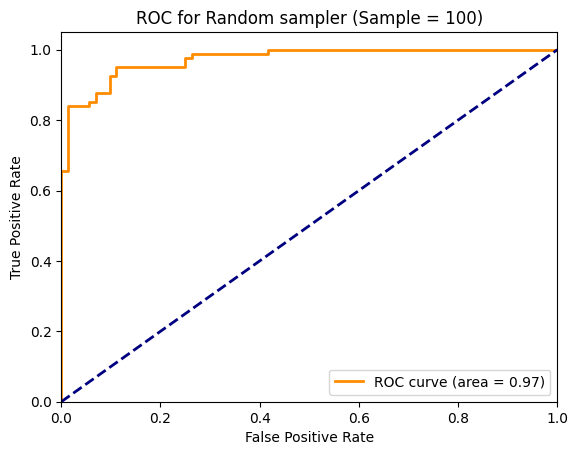

In [152]:
d_rnd = en_bcc_all_exp[0] # 0 and 1 both did not have 100 as key
plot_roc(d_rnd[100][0], d_rnd[100][2], "Random sampler (Sample = 100)") # 100 was not available for the first experiment (index 0)

In [119]:
def find_closest_key(my_dict, target_key):
    closest_key = None
    min_diff = 1000

    for key in my_dict.keys():
        diff = abs(int(key) - target_key)
        if diff < min_diff:
            min_diff = diff
            closest_key = key

    return my_dict[closest_key]

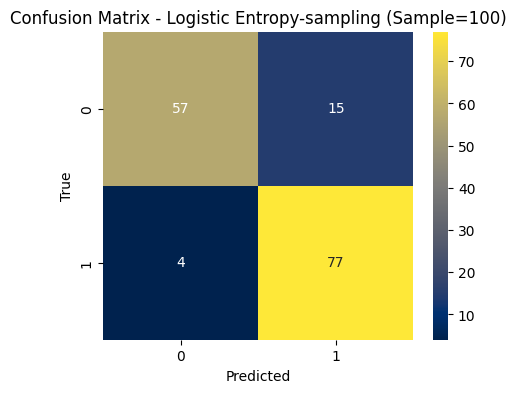

In [153]:
cms = [confusion_matrix(find_closest_key(d_rnd, 100)[0], find_closest_key(d_rnd, 100)[1]) for d_rnd in en_bcc_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(en_bcc_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Logistic Entropy-sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [121]:
lb = min([min(list(en_bcc_all_exp[i].keys())) for i in range(len(en_bcc_all_exp))])
ub = max([max(list(en_bcc_all_exp[i].keys())) for i in range(len(en_bcc_all_exp))])
xrange = np.arange(lb, ub)
auc_arr = []
acc_arr = []
f1_arr  = []
pre_arr = []
rec_arr = []
for exp in en_bcc_all_exp:
    skeys = sorted(exp.keys(), key=lambda x: int(x))
    xvals = []
    aucvals = []
    accvals = []
    f1vals  = []
    prevals = []
    recvals = []
    for key in skeys:
        xvals.append(key)
        truey = exp[key][0]
        predy = exp[key][1]
        proby = exp[key][2]

        # metrics
        rauc = roc_auc_score(truey, proby)
        acc = balanced_accuracy_score(truey, predy)
        f1 = f1_score(truey, predy)
        pre = precision_score(truey, predy)
        rec = recall_score(truey, predy)

        # append
        aucvals.append(rauc)
        accvals.append(acc)
        f1vals.append(f1)
        prevals.append(pre)
        recvals.append(rec)
    
    # interpolate and then append to the outer arrays
    f1vals = np.interp(np.arange(lb, ub), xvals, f1vals)
    accvals = np.interp(np.arange(lb, ub), xvals, accvals)
    aucvals = np.interp(np.arange(lb, ub), xvals, aucvals)
    prevals = np.interp(np.arange(lb, ub), xvals, prevals)
    recvals = np.interp(np.arange(lb, ub), xvals, recvals)
    

    auc_arr.append(aucvals)
    acc_arr.append(accvals)
    f1_arr.append(f1vals)
    pre_arr.append(prevals)
    rec_arr.append(recvals)

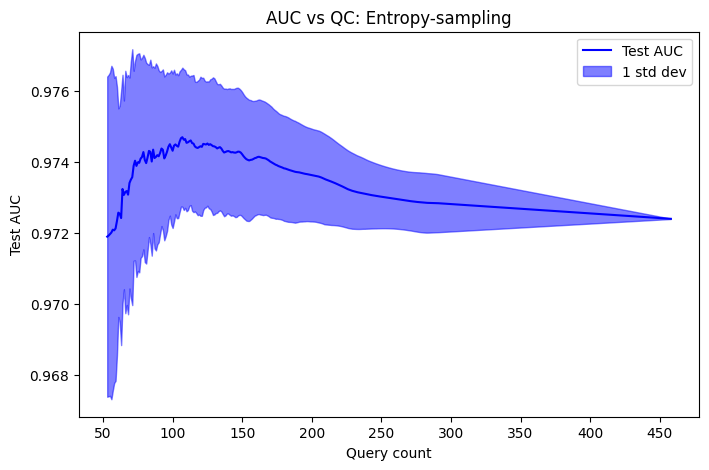

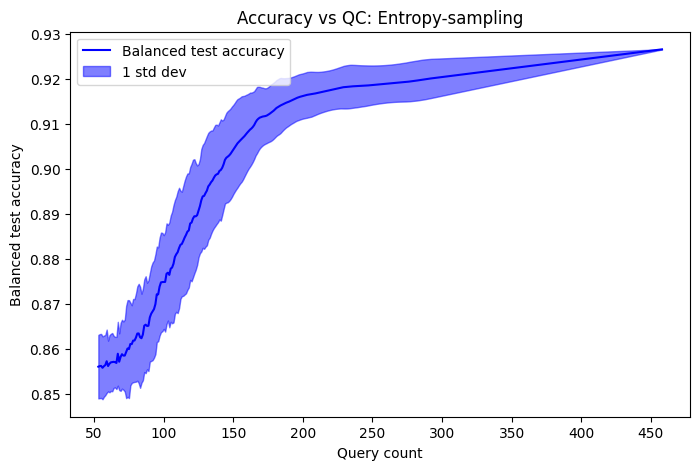

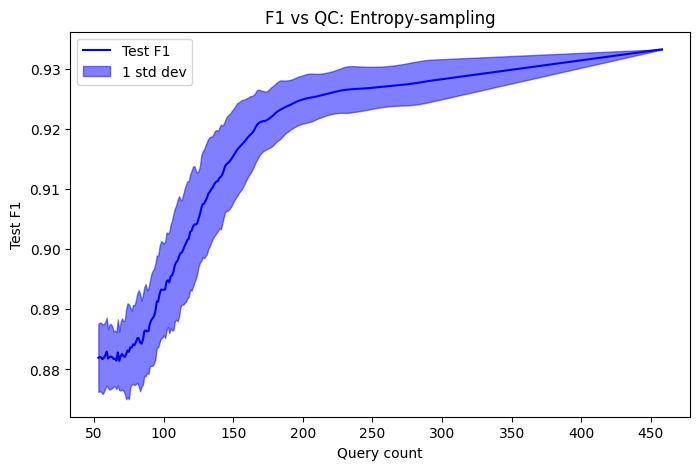

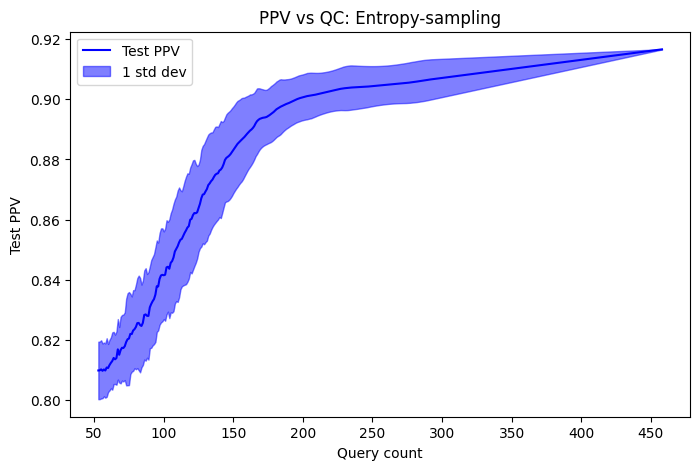

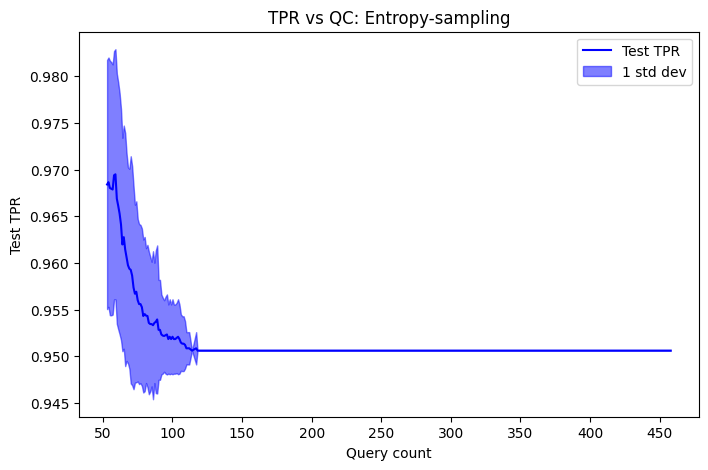

In [122]:
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(auc_arr), axis = 0)], [np.std(np.array(auc_arr), axis = 0)], "Test AUC", "AUC vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(acc_arr), axis = 0)], [np.std(np.array(acc_arr), axis = 0)], "Balanced test accuracy", "Accuracy vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(f1_arr), axis = 0)], [np.std(np.array(f1_arr), axis = 0)], "Test F1", "F1 vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(pre_arr), axis = 0)], [np.std(np.array(pre_arr), axis = 0)], "Test PPV", "PPV vs QC: Entropy-sampling", "Query count")
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(rec_arr), axis = 0)], [np.std(np.array(rec_arr), axis = 0)], "Test TPR", "TPR vs QC: Entropy-sampling", "Query count")

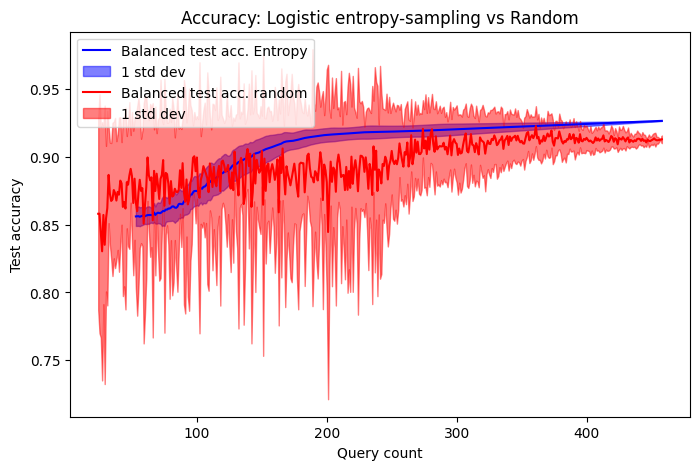

In [129]:
# Compare random and entropy
fill_between_plot_diffx([np.arange(lb, ub), np.arange(24, X_train_top_f.shape[0], 1)], [np.mean(np.array(acc_arr), axis = 0), avg_acc_rnd], [np.std(np.array(acc_arr), axis = 0), std_acc], ["Balanced test acc. Entropy", "Balanced test acc. random"], "Accuracy: Logistic entropy-sampling vs Random", "Test accuracy", "Query count")

#### Plot the entropy (~anomaly score)

In [130]:
def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

In [154]:
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in X_train_top_f
]
y_river = y_train.tolist() 

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression(l2 = 0.1)
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

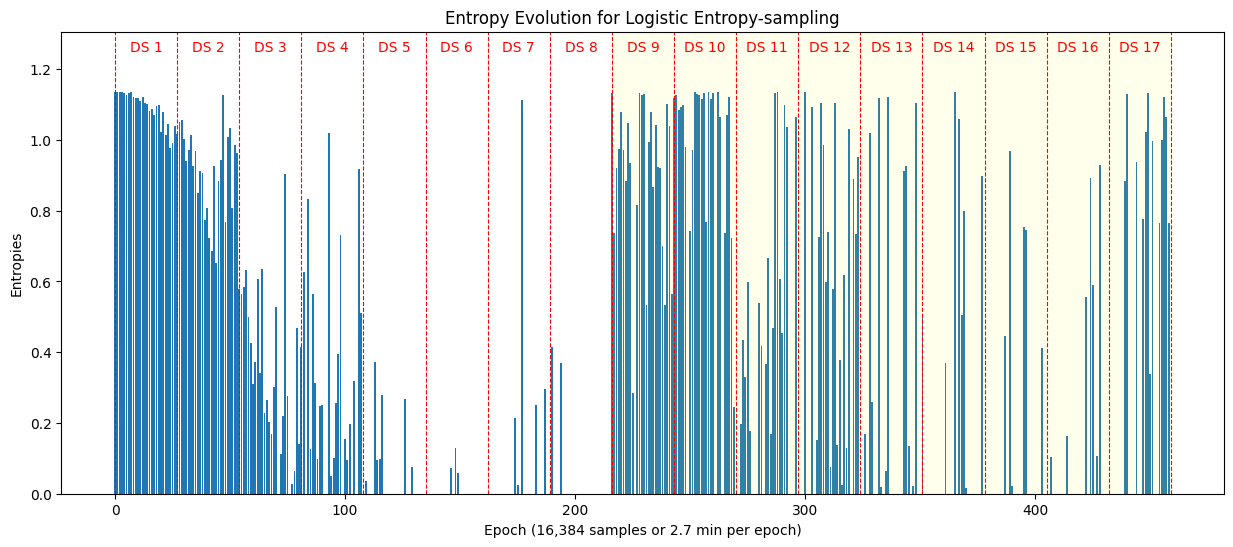

In [156]:
## plot the anomalies
sns.reset_defaults()
sns.reset_orig()
plt.figure(figsize=(15, 6))

nbr_epochs = X_train_top_f.shape[0]
entropies_reshaped = np.array(entropies).reshape(-1, 1)

# plot dashed line separators for the damage classes
for i in range(0, nbr_epochs+1, 27):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

# scale the entropies and plot them 
sc = StandardScaler()
obs = np.arange(len(entropies))
std_entropies = sc.fit_transform(entropies_reshaped).flatten()
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

# color the damage states
plt.axvspan(27*8, 27*17, color='yellow', alpha=0.08)
plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Entropies')
plt.title(f'Entropy Evolution for Logistic Entropy-sampling')

# add texts with DS 1, DS 2, etc.
text_pos = [i+13.5 for i in range(0, nbr_epochs, 27)]
for idx, pos in enumerate(text_pos):
    plt.text(pos, max(std_entropies)*1.1, f'DS {idx+1}', ha='center', color='red')

plt.show()

In [306]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=42).fit(X_train_top_f)
balanced_accuracy_score(y_test, gm.predict(X_test_top_f))

0.7939814814814814

### Method 2: Changepoint detection using Gaussian scoring

In [347]:
def gaussian_scorer_multi(y_values, window_size = 25, grace_period = 10, method = 0, plot = True):
    """
    Method: 0 if min of Gaussian anomaly scores for each variable, 1 if max of Gaussian anomaly scores, and 2 if product of scores, 3 if median of scores
    """
    global X_train_top_f
    from functools import reduce
    # initialize Gaussian anomaly detectors for eachb
    num_vals = y_values.shape[1]
    detectors = [anomaly.GaussianScorer(window_size=window_size, grace_period=grace_period) for el in range(num_vals)]
    anomaly_scores = [[0] for el in range(num_vals)]  

    # learn on one instance, score on the next
    for idx, detector in enumerate(detectors):
        for obs_idx, y in enumerate(y_values[:-1, idx]):
            detector = detector.learn_one(None, y) 
            anomaly_scores[idx].append(detector.score_one(None, y_values[obs_idx+1, idx]))
    
    # calculate the reductions (0 for minimum, 1 for maximum, 2 for product, else median)
    anomaly_scores_np = [np.array(el) for el in anomaly_scores]
    result = np.minimum.reduce(anomaly_scores_np) if method == 0 else \
         np.maximum.reduce(anomaly_scores_np) if method == 1 else reduce(np.multiply, anomaly_scores_np) if method == 2 else np.median(np.vstack(anomaly_scores_np), axis=0)
    mnmx = StandardScaler()
    obs = np.arange(len(result))
    normalized_result = mnmx.fit_transform(result.reshape(-1, 1)).flatten()
    
    # plot the anomalies
    if plot:
        import matplotlib.pyplot as plt
        # reset seaborn
        sns.reset_defaults()
        sns.reset_orig()
        plt.figure(figsize=(15, 6))

        # plot dashed line separators for each damage state
        nbr_epochs = X_train_top_f.shape[0]
        for i in range(0, nbr_epochs+1, 27):
            plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
        
        # plot the anomaly scores
        plt.bar(obs, normalized_result)
        plt.ylim(0, 1.15*max(normalized_result))
        
        # color the damage state
        plt.axvspan(27*8, 27*17, color='yellow', alpha=0.08)

        # set up labels and text header for each damage scenario/segment
        string_method = "min_i" if method == 0 else "max_i" if method == 1 else "\prod_i" if method == 2 else "med_i"
        plt.xlabel('Epoch (16,384 samples or 2.7 min per observation)')
        plt.ylabel('(Standardized) Gaussian anomaly score')
        plt.title(rf'Gaussian Anomaly Window: $anomaly = 2\ {string_method} \|CDF(x_i) - 0.5\|$')
        
        # damage state header
        text_pos = [i+13.5 for i in range(0, nbr_epochs, 27)]
        for idx, pos in enumerate(text_pos):
            plt.text(pos, max(normalized_result)*1.1, f'DS {idx+1}', ha='center', color='red')

        plt.show()
    return result, normalized_result

In [187]:
def plot_distribution(data, title, window = None, threshold = None, damage_zone = None):    
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    
    if window is not None:
        data = data[np.logical_and(data >= window[0], data <= window[1])]
    
    if threshold is not None and damage_zone is None:
        below_threshold = data[data < threshold]
        above_threshold = data[data >= threshold]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold, bins='auto', color='cyan', edgecolor='black', label='Above Threshold')
        plt.legend()
    elif threshold is not None and damage_zone is not None:
        below_threshold = data[data < threshold]
        above_threshold_idx = np.where(data >= threshold)[0]
        print(above_threshold_idx)
        above_threshold_damage = [data[idx] for idx in above_threshold_idx if damage_zone(idx)]
        above_threshold_nodam = [data[idx] for idx in above_threshold_idx if not damage_zone(idx)]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold_nodam, bins='auto', color='cyan', edgecolor='black', label='Above Threshold (Undamaged)')
        sns.histplot(above_threshold_damage, bins='auto', alpha = 0.6, color='red', edgecolor='black', label='Above Threshold (Damaged)')
        print(f"{len(below_threshold)} are below threshold, {len(above_threshold_damage)} are above threshold with damaged, and {len(above_threshold_nodam)} are above threshold undamaged")
        plt.legend()
    else:
        sns.histplot(data, bins='auto', color='#86bf91', edgecolor='black')

    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Standardized anomaly score', fontsize=14, labelpad=15)
    plt.ylabel('Frequency', fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
    
    sns.reset_defaults()
    sns.reset_orig()

In [358]:
def stacked_bar_plot(X, labels, title, width = 10):
    # Creating the DataFrame for seaborn
    label_names = {0: "Healthy", 1: "Damaged"}
    df = pd.DataFrame({'X': X, 'Labels': labels})
    df['Labels'] = df['Labels'].map(label_names)
    # Plotting using seaborn
    plt.figure(figsize=(width, 6))
    label_colors = {"Healthy": "cyan", "Damaged": "red"}
    ax = sns.histplot(data=df, x='X', hue='Labels', bins=12, multiple='stack', palette=label_colors)

    # Get the patches (rectangles) of the histogram
    patches = ax.patches
    bin_counts = len(patches) // 2  # assuming two labels (0 and 1)

    # Calculate the total counts in each bin
    total_counts = [patches[i].get_height() + patches[i + bin_counts].get_height() for i in range(bin_counts)]

    # Annotate each bin with the percentage of blue
    for i in range(bin_counts):
        blue_height = patches[i].get_height()
        percentage_blue = (blue_height / total_counts[i]) * 100 if total_counts[i] != 0 else 0
        ax.text(patches[i].get_x() + patches[i].get_width() / 2, total_counts[i], f'{percentage_blue:.1f}%', ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Standardized anomaly score')
    plt.ylabel('Frequency')
    plt.show()

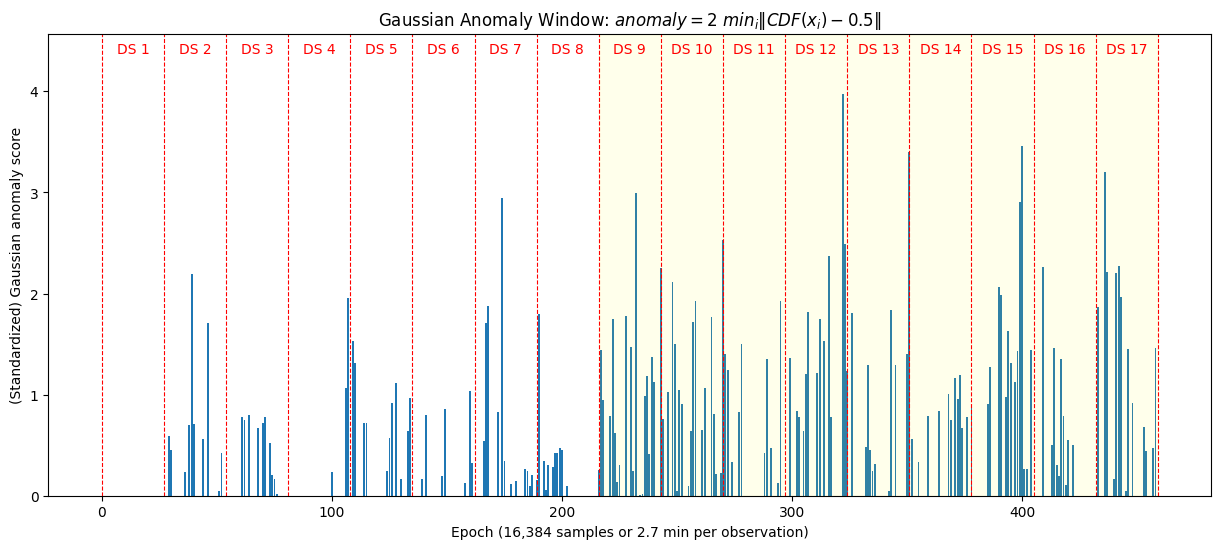

In [348]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20)

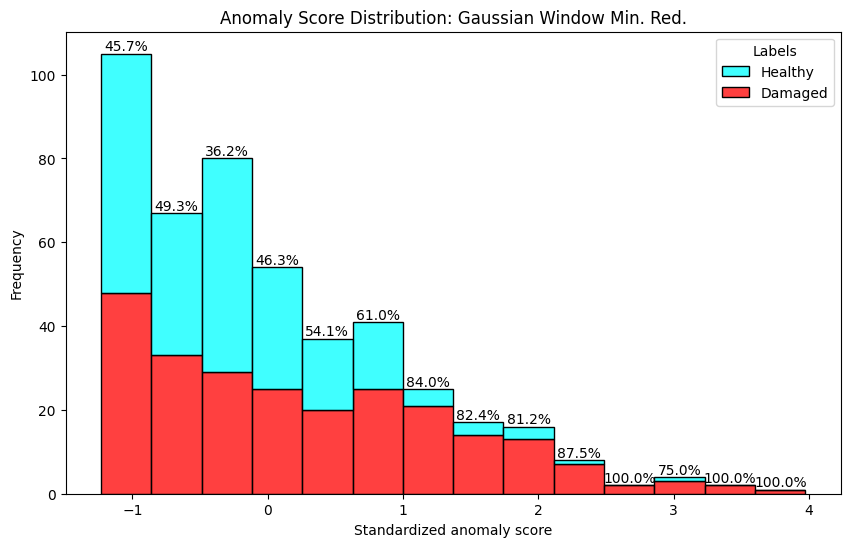

In [349]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Min. Red.")

In [350]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result), np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]])

(array([216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235], dtype=int64),
 322,
 0.84,
 0.8888888888888888)

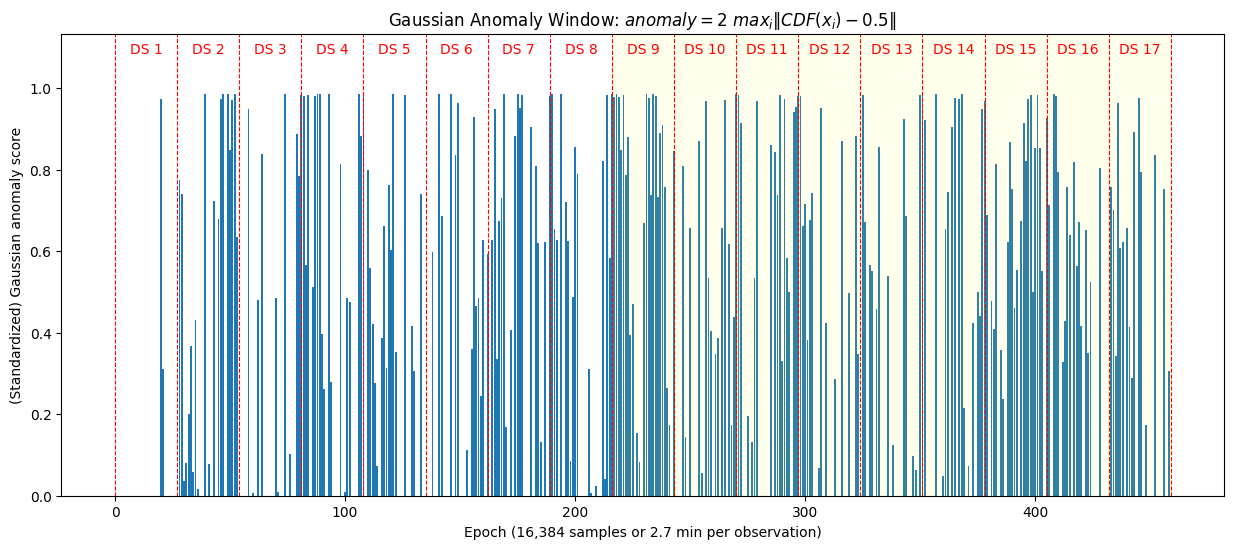

In [351]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20, method = 1) # max this time. REMARK: graph is very noisy. Taking a max is not a great idea

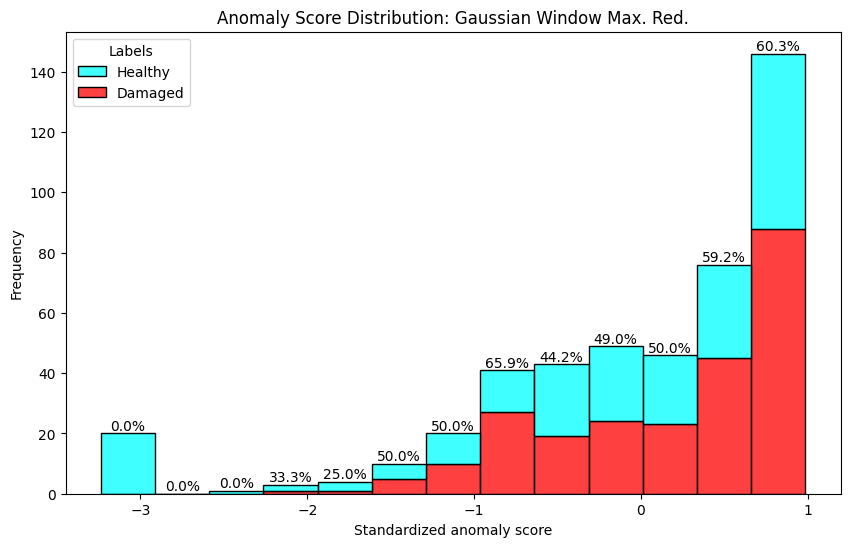

In [352]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Max. Red.") # does not make any sense

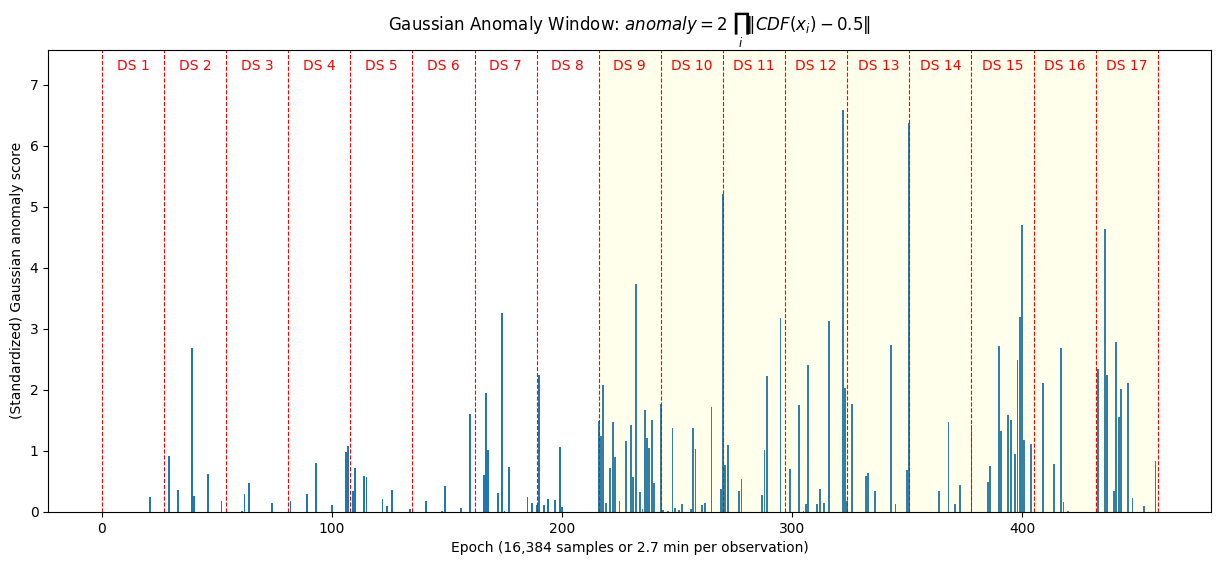

In [500]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size =25, grace_period = 20, method = 2) # product this time

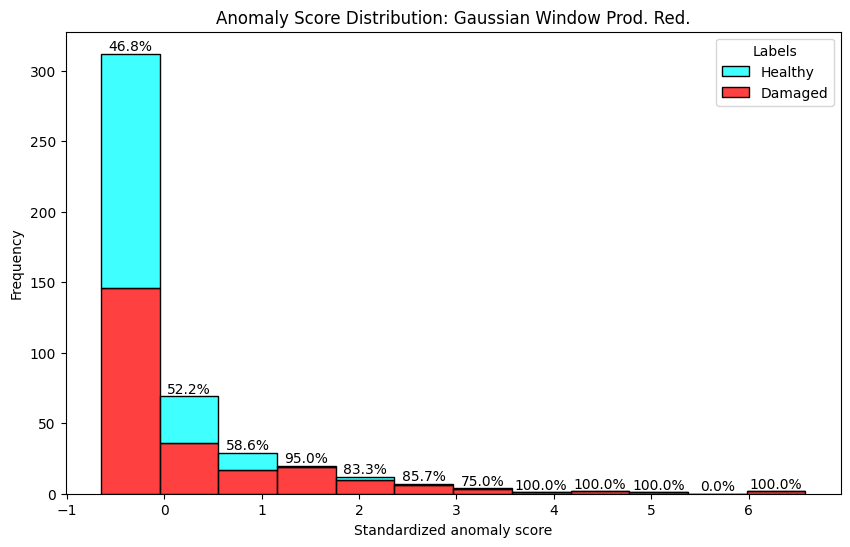

In [501]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Prod. Red.", width=10) 

In [502]:
np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]]) 

(0.8596491228070176, 0.8846153846153846)

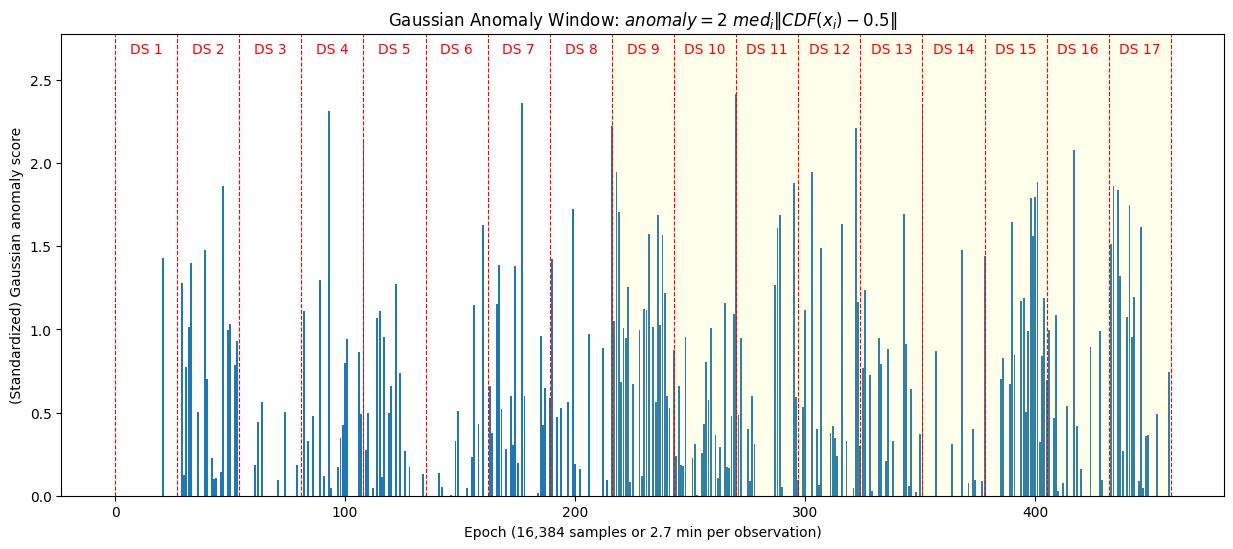

In [330]:
result, n_res = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20, method = 3) # median this time

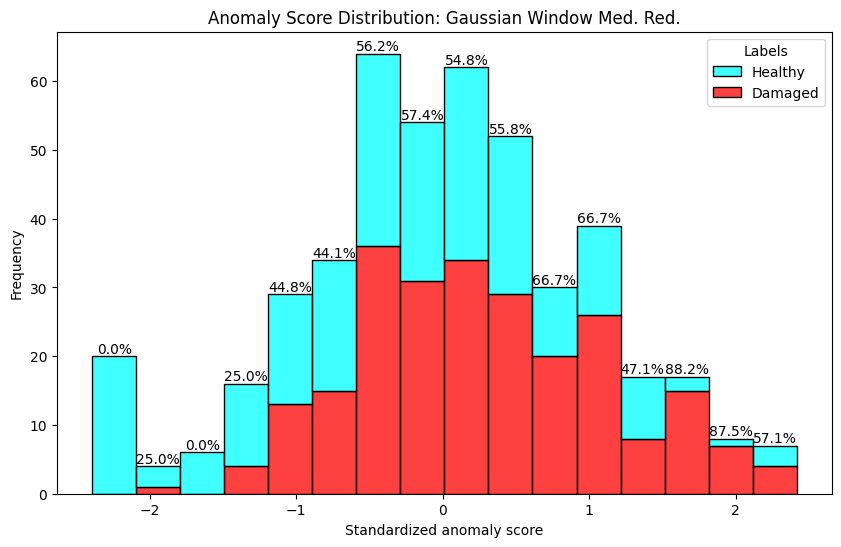

In [331]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: Gaussian Window Med. Red.") 

In [332]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result), np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]]) 

(array([216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235], dtype=int64),
 0.9940197188818752,
 270,
 0.6986301369863014,
 0.625)

In [363]:
# turn these methods into AL algorithms
class AL:
    def __init__(self, anomaly_scores, query_count, labels_after_chgpt, warm_start = False):
        self.anomaly_scores = anomaly_scores
        self.labels_after_chgpt = labels_after_chgpt # how many samples to query after changepoint
        self.warm_start = warm_start
        self.query_count = query_count
    def query(self):
        self.sample_points = np.argsort(self.anomaly_scores)[::-1][:self.query_count]
        return self.sample_points # these are only start points of sampling
    def get_label_points(self): # indices of samples to label
        self.query()
        querying_points = []
        # avoid sampling across boundaries 
        def boundary(num):
            bin = num // 27
            return 27*(bin+1) - 1
        [[querying_points.append(min(num+i, boundary(num))) for i in range(self.labels_after_chgpt)] for num in self.sample_points]
        # warm start, comment the next line to avoid warm start
        if self.warm_start:
            querying_points = querying_points + list(range(10))
        res = list(set(querying_points))
        res.sort()
        return res

In [450]:
def ad_to_al(normalized_res, warm_st):
    global y_train, X_train_top_f
    # dictionary to store true_y, pred_y, and prob_y
    warm_cnt = 5 if warm_st else 0
    exp_dict = {}
    budget = np.array([10, 20, 30, 40, 50, 60, 70, 80, 95, 100, 110, 130, 150, 200, 250, 300, 350, 400]) 
    indices_ordered = np.argsort(normalized_res)[::-1]
    
    for i in budget:
        # get subset of data
        indices = indices_ordered[:i] if warm_st == False else np.hstack((indices_ordered[:i], np.arange(warm_cnt)))
        train_data = X_train_top_f[indices, :]
        train_labels = y_train[indices]
        
        # train the model
        log_reg = GridSearchCV(LogisticRegression(), param_grid_bcc_log, scoring = 'accuracy', cv = 5)  
        log_reg.fit(train_data, train_labels)
        y_pred = log_reg.predict(X_test_top_f)
        pred_proba_y = log_reg.predict_proba(X_test_top_f)[:, 1]
        
        # log data
        exp_dict[i + warm_cnt] = [y_test, y_pred, pred_proba_y]

    return exp_dict

In [451]:
_, n_res_min = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20, method = 0, plot=False) # min this time
min_g_exp = ad_to_al(n_res_min, warm_st=True)
_, n_res_prod = gaussian_scorer_multi(X_train_top_f, window_size = 25, grace_period = 20, method = 2, plot=False) # prod this time
prod_g_exp = ad_to_al(n_res_prod, warm_st=True)

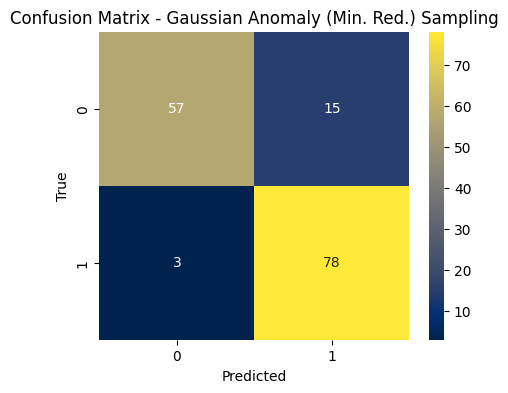

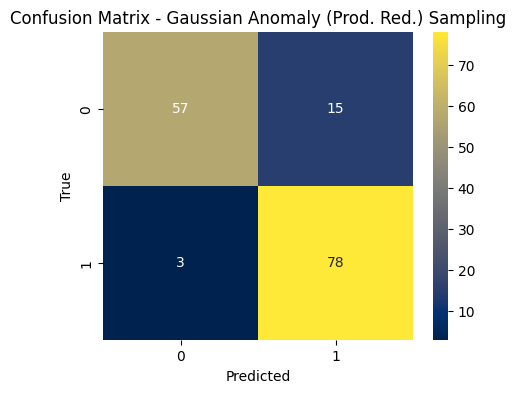

In [453]:
cm = confusion_matrix(min_g_exp[100][0], min_g_exp[100][1]) 
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Gaussian Anomaly (Min. Red.) Sampling")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

cm = confusion_matrix(prod_g_exp[100][0], prod_g_exp[100][1]) 
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Gaussian Anomaly (Prod. Red.) Sampling")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [454]:
prod_g_exp.keys()

dict_keys([15, 25, 35, 45, 55, 65, 75, 85, 100, 105, 115, 135, 155, 205, 255, 305, 355, 405])

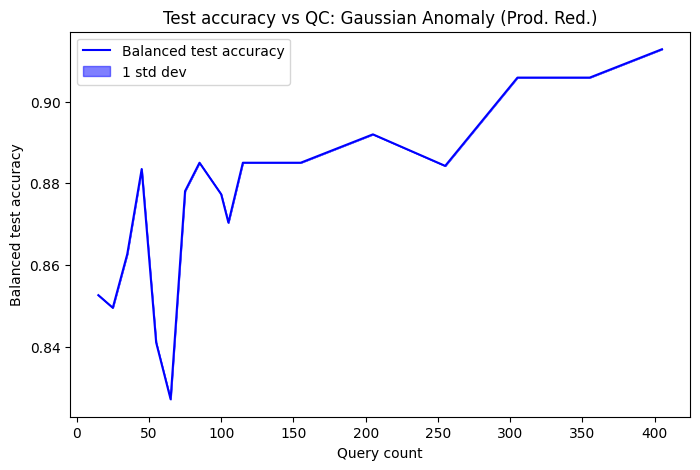

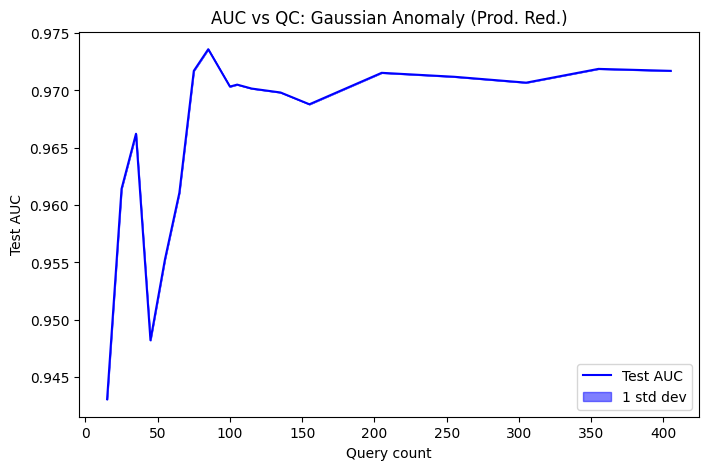

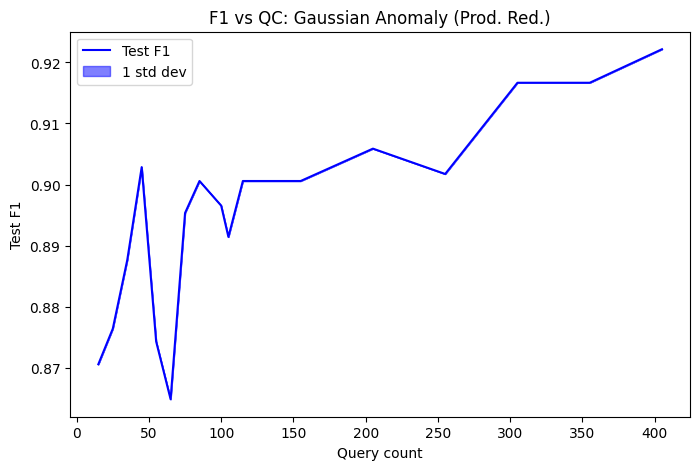

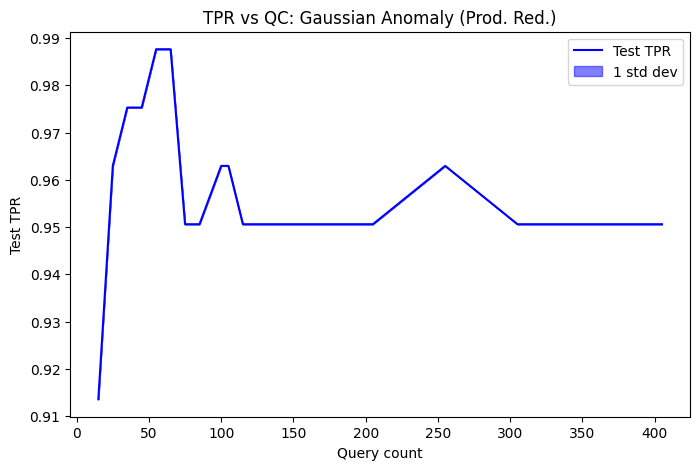

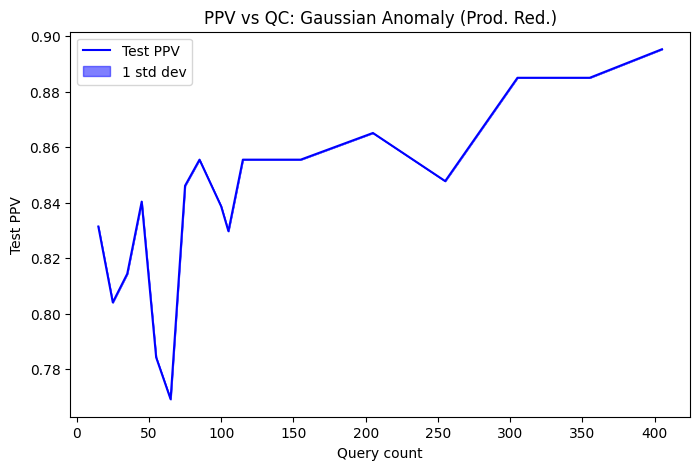

In [455]:
xrange = np.array(list(prod_g_exp.keys())) 
acc_prod_g = np.array(all_accu_score(xrange, [prod_g_exp]))
avg_acc_prod_g = np.mean(acc_prod_g, axis = 0)
std_acc_prod_g = np.std(acc_prod_g, axis = 0)

auc_prod_g = np.array(all_auc(xrange, [prod_g_exp]))
avg_auc_prod_g = np.mean(auc_prod_g, axis = 0)
std_auc_prod_g = np.std(auc_prod_g, axis = 0)

f1_prod_g = np.array(all_f1_score(xrange, [prod_g_exp]))
avg_f1_prod_g = np.mean(f1_prod_g, axis = 0)
std_f1_prod_g = np.std(f1_prod_g, axis = 0)

rec_prod_g = np.array(all_recall_score(xrange, [prod_g_exp]))
avg_rec_prod_g = np.mean(rec_prod_g, axis = 0)
std_rec_prod_g = np.std(rec_prod_g, axis = 0)

pre_prod_g = np.array(all_precision_score(xrange, [prod_g_exp]))
avg_pre_prod_g = np.mean(pre_prod_g, axis = 0)
std_pre_prod_g = np.std(pre_prod_g, axis = 0)

fill_between_plot(xrange, [avg_acc_prod_g], [std_acc_prod_g], "Balanced test accuracy", "Test accuracy vs QC: Gaussian Anomaly (Prod. Red.)", "Query count")
fill_between_plot(xrange, [avg_auc_prod_g], [std_auc_prod_g], "Test AUC", "AUC vs QC: Gaussian Anomaly (Prod. Red.)", "Query count")
fill_between_plot(xrange, [avg_f1_prod_g], [std_f1_prod_g], "Test F1", "F1 vs QC: Gaussian Anomaly (Prod. Red.)", "Query count")
fill_between_plot(xrange, [avg_rec_prod_g], [std_rec_prod_g], "Test TPR", "TPR vs QC: Gaussian Anomaly (Prod. Red.)", "Query count")
fill_between_plot(xrange, [avg_pre_prod_g], [std_pre_prod_g], "Test PPV", "PPV vs QC: Gaussian Anomaly (Prod. Red.)", "Query count")

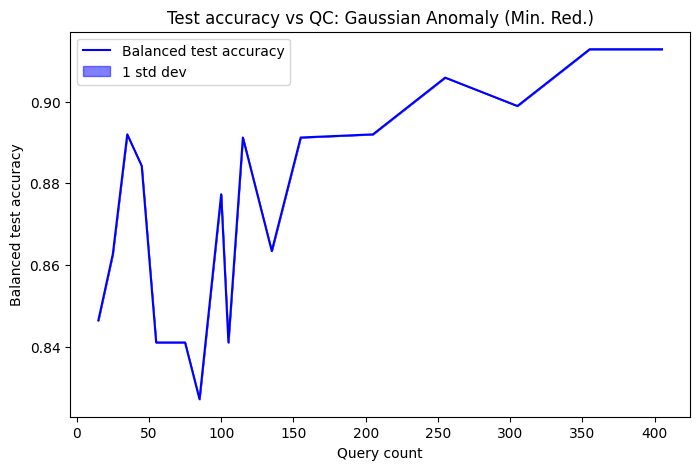

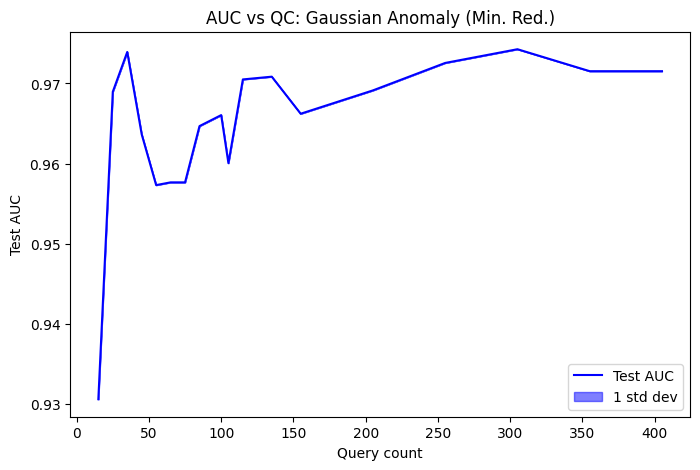

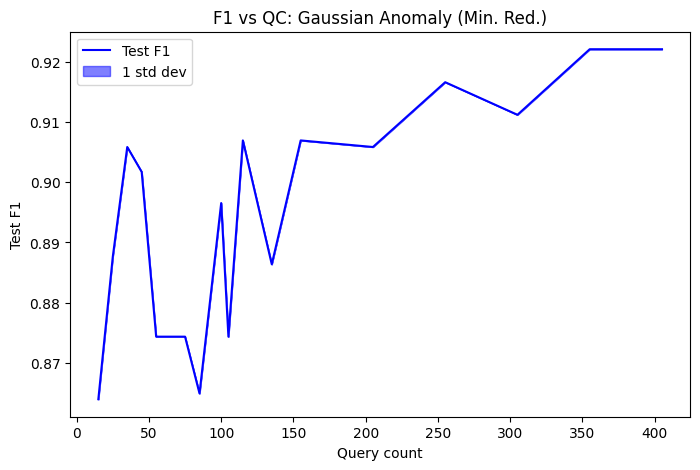

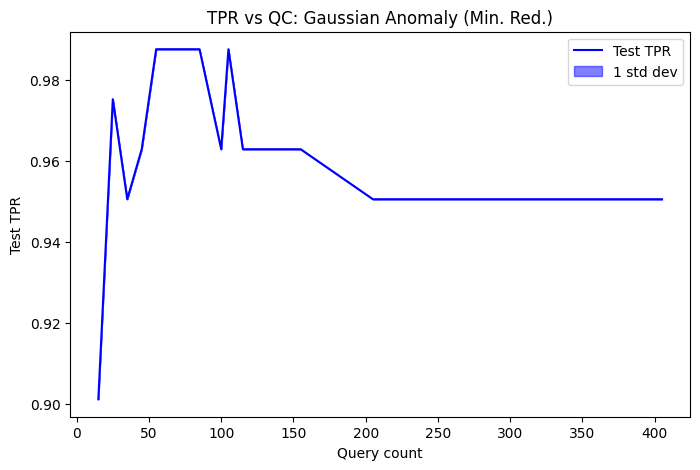

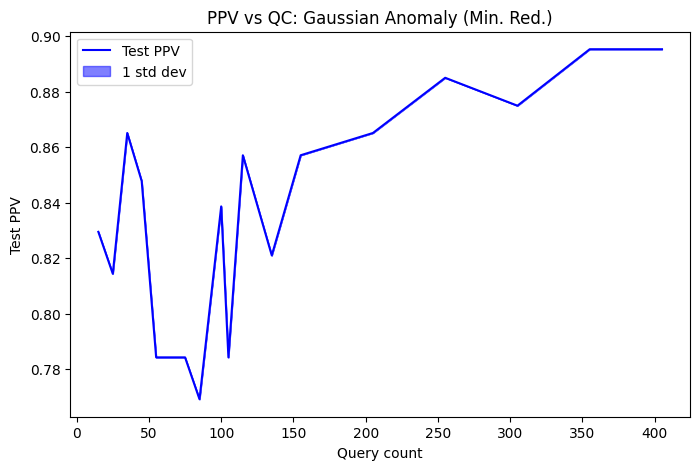

In [456]:
xrange = list(min_g_exp.keys())
acc_min_g = np.array(all_accu_score(xrange, [min_g_exp]))
avg_acc_min_g = np.mean(acc_min_g, axis = 0)
std_acc_min_g = np.std(acc_min_g, axis = 0)

auc_min_g = np.array(all_auc(xrange, [min_g_exp]))
avg_auc_min_g = np.mean(auc_min_g, axis = 0)
std_auc_min_g = np.std(auc_min_g, axis = 0)

f1_min_g = np.array(all_f1_score(xrange, [min_g_exp]))
avg_f1_min_g = np.mean(f1_min_g, axis = 0)
std_f1_min_g = np.std(f1_min_g, axis = 0)

rec_min_g = np.array(all_recall_score(xrange, [min_g_exp]))
avg_rec_min_g = np.mean(rec_min_g, axis = 0)
std_rec_min_g = np.std(rec_min_g, axis = 0)

pre_min_g = np.array(all_precision_score(xrange, [min_g_exp]))
avg_pre_min_g = np.mean(pre_min_g, axis = 0)
std_pre_min_g = np.std(pre_min_g, axis = 0)

fill_between_plot(xrange, [avg_acc_min_g], [std_acc_min_g], "Balanced test accuracy", "Test accuracy vs QC: Gaussian Anomaly (Min. Red.)", "Query count")
fill_between_plot(xrange, [avg_auc_min_g], [std_auc_min_g], "Test AUC", "AUC vs QC: Gaussian Anomaly (Min. Red.)", "Query count")
fill_between_plot(xrange, [avg_f1_min_g], [std_f1_min_g], "Test F1", "F1 vs QC: Gaussian Anomaly (Min. Red.)", "Query count")
fill_between_plot(xrange, [avg_rec_min_g], [std_rec_min_g], "Test TPR", "TPR vs QC: Gaussian Anomaly (Min. Red.)", "Query count")
fill_between_plot(xrange, [avg_pre_min_g], [std_pre_min_g], "Test PPV", "PPV vs QC: Gaussian Anomaly (Min. Red.)", "Query count")

### Method 3: ARIMA

In [474]:
import numpy as np
import arimafd as oa
import sys
from io import StringIO
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from preprocess import get_avt_files, get_dataframes, preprocess_without_std

In [37]:
# get the acceleration signals
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs_acc = get_dataframes(avt_files)
dfs_acc = pd.concat(dfs_acc, axis=0)
dfs_acc.reset_index(drop=True, inplace=True)
dfs_acc = dfs_acc.apply(lambda x: preprocess_without_std(x), axis=0) 
dfs_acc.shape

(10027008, 5)

In [ ]:
batch_size = 16384 # try with half of this also
nbr_samples = dfs_acc.shape[0]
change_points = []
windows = int(nbr_samples/batch_size) #  nbr of windows
anomalies= []

for i in range(windows):
    print(f"--- iter {i} ---")
    arima = oa.Arima_anomaly_detection(ar_order=4)
    window_1 = dfs_acc[i*batch_size:(i+1)*batch_size]
    window_2 = dfs_acc[(i+1)*batch_size:(i+2)*batch_size]
    arima.fit(window_1, window = int(batch_size//2), window_insensitivity = batch_size - 1)
    ts_anomaly = arima.predict(window_2, window = int(batch_size//2), window_insensitivity= batch_size - 1)
    np.save(f"arima_{i}.npy", ts_anomaly.to_numpy())

In [470]:
len(np.sort(test_idx)), len(np.sort(train_idx))

(153, 459)

In [539]:
def plot_anomalies(title, path, grace = 1):
    global X_train_top_f
    # first window always healthy
    perc_ones = [0] # percent of ones in each window
    nbr_epochs = X_train_top_f.shape[0]
    tot_epochs = 611
    for i in range(grace, tot_epochs): # 0 is already included inside training
        if i in train_idx:
            cur_window = np.load(f"{path}/arima_{i}.npy")
            position_ones = np.where(cur_window == 1)[0]
            perc_ones.append(len(position_ones)/batch_size)

    scaler = StandardScaler()
    counts = scaler.fit_transform(np.array(perc_ones).reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 6)) 
    print(len(counts), np.where(counts > 3.5)[0])
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Epoch (2.7 min ~ 16,384 samples)')
    plt.ylabel('(Standardized) percent of anomalies per epoch')
    plt.axvspan(27*8, 27*17, color='yellow', alpha=0.08)
    plt.ylim(0, 1.15*max(counts))
    plt.title(title)

    for i in range(0, nbr_epochs+1, int(nbr_epochs/17)):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    text_pos = [i+int(nbr_epochs/(2*17)) for i in range(0, nbr_epochs, int(nbr_epochs/17))]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, max(counts)*0.9, f'DS {idx+1}', ha='center', color='red')

    plt.show()

    return counts

460 [ 25  55 158 200 205 213 412]


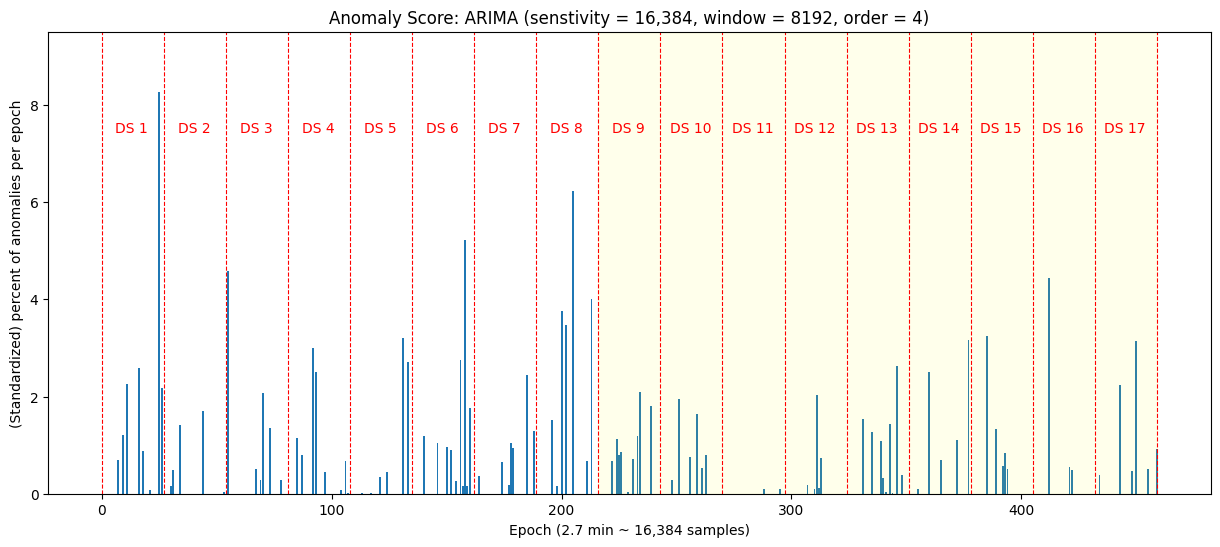

In [472]:
n_res = plot_anomalies("Anomaly Score: ARIMA (senstivity = 16,384, window = 8192, order = 4)", "./arima_16383_sens_8192_win")

459 [ 18  44 170 173 228 356]


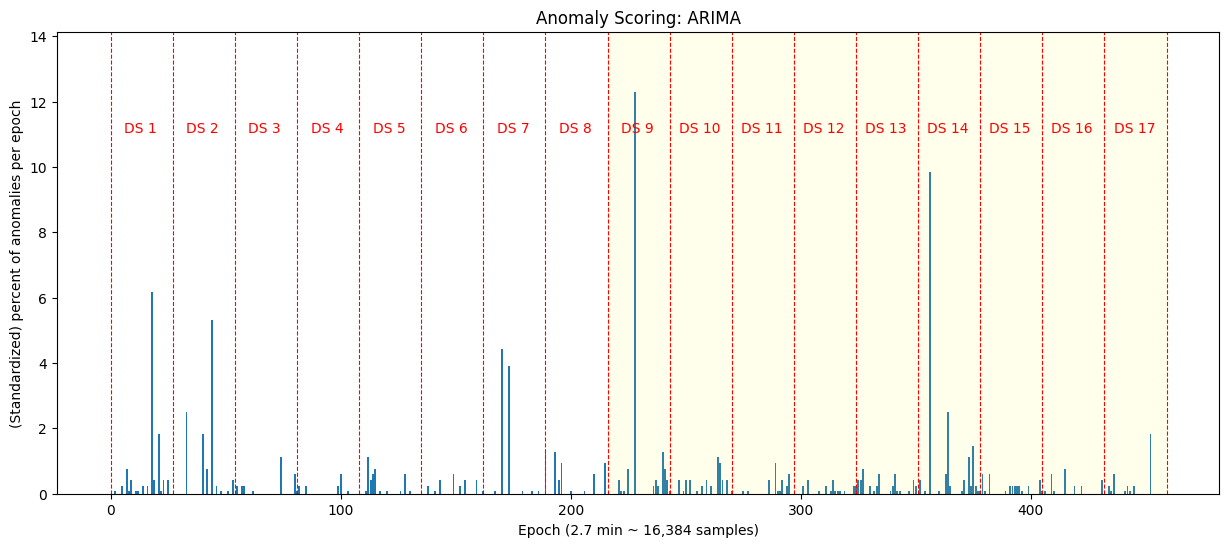

In [513]:
n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_100_sens_100_win") 

In [514]:
exp_arima_time = ad_to_al(n_res, warm_st=True)

c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


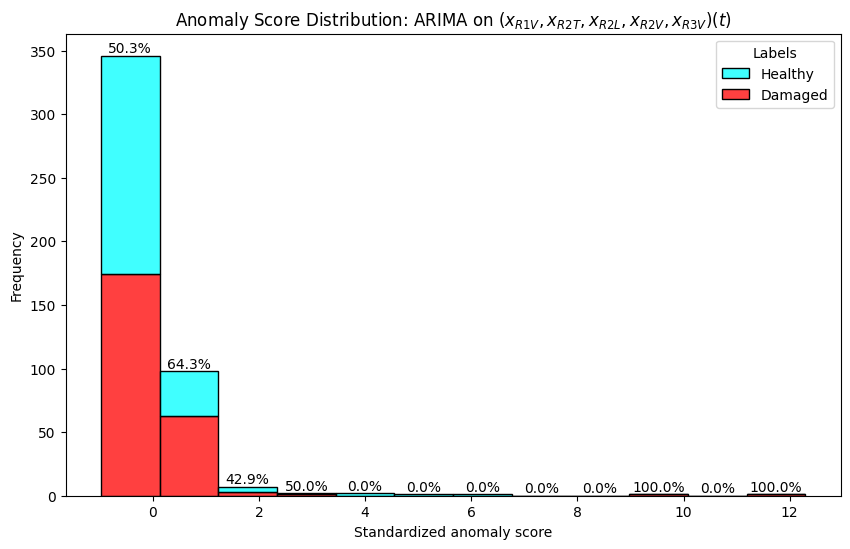

In [515]:
stacked_bar_plot(n_res, y_train, "Anomaly Score Distribution: ARIMA on $(x_{R1V}, x_{R2T}, x_{R2L}, x_{R2V}, x_{R3V})(t)$")

In [516]:
np.sum(y_train[np.where(n_res > 1)[0]])/len(y_train[np.where(n_res > 1)[0]]), np.sum(y_train[np.where(n_res > 2)[0]])/len(y_train[np.where(n_res > 2)[0]]), np.sum(y_train[np.where(n_res > 8)[0]])/len(y_train[np.where(n_res > 8)[0]])

(0.42105263157894735, 0.375, 1.0)

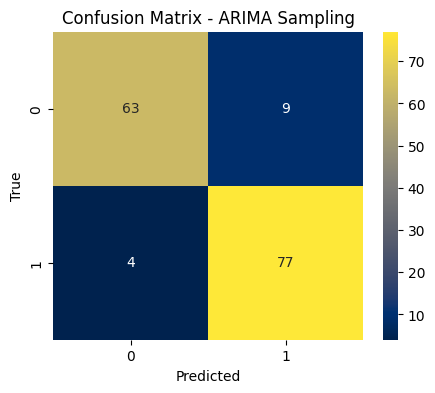

In [517]:
cm = confusion_matrix(exp_arima_time[100][0], exp_arima_time[100][1]) 
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - ARIMA Sampling")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

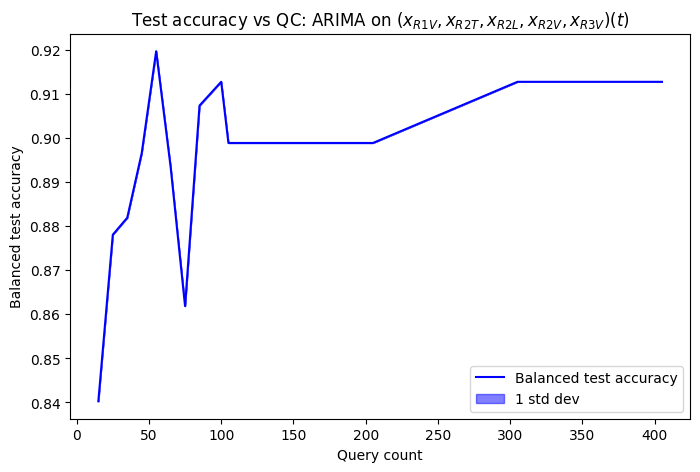

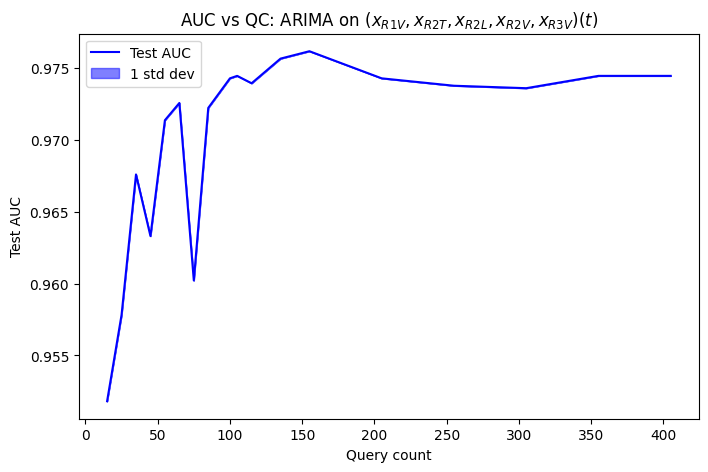

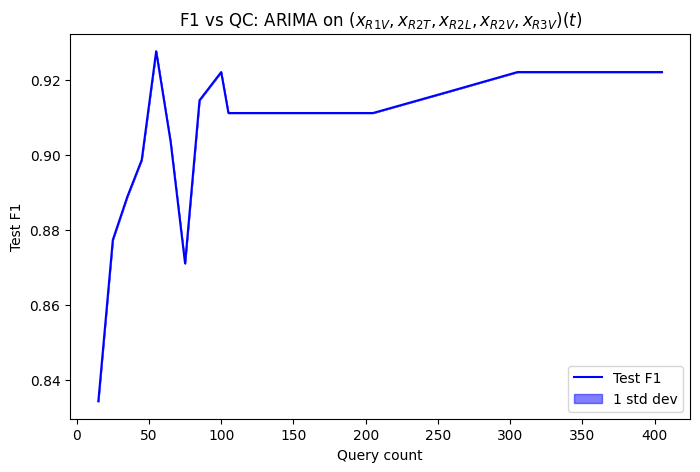

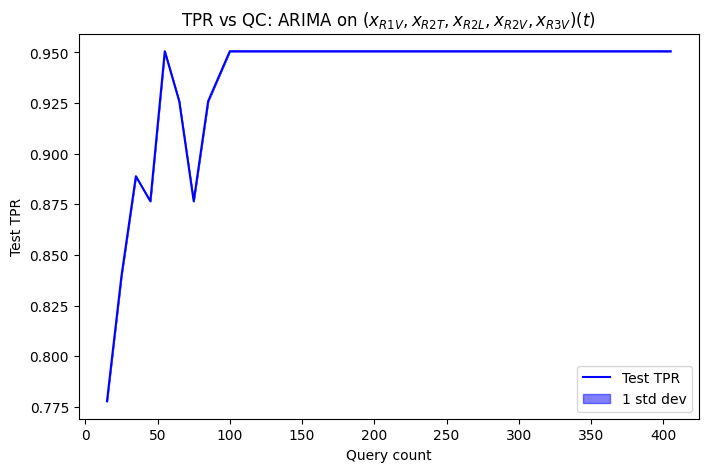

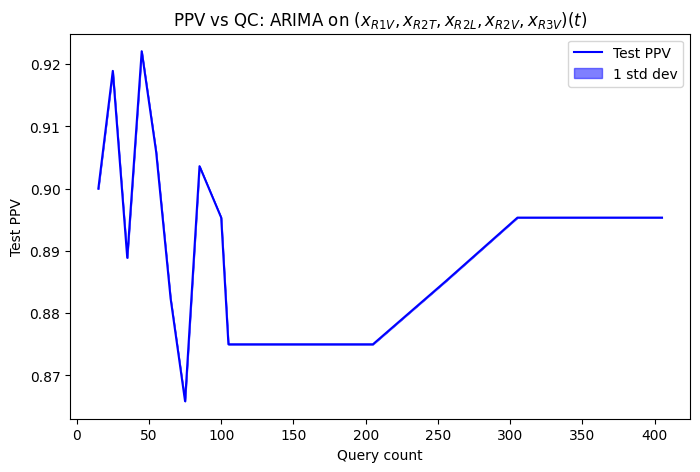

In [519]:
xrange = np.array(list(exp_arima_time.keys())) 
acc_arima = np.array(all_accu_score(xrange, [exp_arima_time]))
avg_acc_arima = np.mean(acc_arima, axis = 0)
std_acc_arima = np.std(acc_arima, axis = 0)

auc_arima = np.array(all_auc(xrange, [exp_arima_time]))
avg_auc_arima = np.mean(auc_arima, axis = 0)
std_auc_arima = np.std(auc_arima, axis = 0)

f1_arima = np.array(all_f1_score(xrange, [exp_arima_time]))
avg_f1_arima = np.mean(f1_arima, axis = 0)
std_f1_arima = np.std(f1_arima, axis = 0)

rec_arima = np.array(all_recall_score(xrange, [exp_arima_time]))
avg_rec_arima = np.mean(rec_arima, axis = 0)
std_rec_arima = np.std(rec_arima, axis = 0)

pre_arima = np.array(all_precision_score(xrange, [exp_arima_time]))
avg_pre_arima = np.mean(pre_arima, axis = 0)
std_pre_arima = np.std(pre_arima, axis = 0)

fill_between_plot(xrange, [avg_acc_arima], [std_acc_arima], "Balanced test accuracy", "Test accuracy vs QC: ARIMA on $(x_{R1V}, x_{R2T}, x_{R2L}, x_{R2V}, x_{R3V})(t)$", "Query count")
fill_between_plot(xrange, [avg_auc_arima], [std_auc_arima], "Test AUC", "AUC vs QC: ARIMA on $(x_{R1V}, x_{R2T}, x_{R2L}, x_{R2V}, x_{R3V})(t)$", "Query count")
fill_between_plot(xrange, [avg_f1_arima], [std_f1_arima], "Test F1", "F1 vs QC: ARIMA on $(x_{R1V}, x_{R2T}, x_{R2L}, x_{R2V}, x_{R3V})(t)$", "Query count")
fill_between_plot(xrange, [avg_rec_arima], [std_rec_arima], "Test TPR", "TPR vs QC: ARIMA on $(x_{R1V}, x_{R2T}, x_{R2L}, x_{R2V}, x_{R3V})(t)$", "Query count")
fill_between_plot(xrange, [avg_pre_arima], [std_pre_arima], "Test PPV", "PPV vs QC: ARIMA on $(x_{R1V}, x_{R2T}, x_{R2L}, x_{R2V}, x_{R3V})(t)$", "Query count")

In [518]:
avg_acc_arima[list(exp_arima_time.keys()).index(100)], balanced_accuracy_score(exp_arima_time[100][0], exp_arima_time[100][1])

(0.8773148148148148, 0.9128086419753086)

#### Supplementary: Example usage of RiverML on iris from Sklearn

In [79]:
"""
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics

# Load the iris dataset from sklearn
iris_sk = skdatasets.load_iris()

# Prepare the data in a format compatible with river
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in iris_sk['data']
]
y_river = iris_sk['target'].tolist()  # Converting to list for easier iteration

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, seed=42)

n_samples_used = 0

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

print(metric)
print(f"Number of samples used for learning: {n_samples_used}")
"""

'\nfrom sklearn import datasets as skdatasets  # Import to avoid naming conflicts\nfrom river import active\nfrom river import datasets\nfrom river import linear_model\nfrom river import metrics\n\n# Load the iris dataset from sklearn\niris_sk = skdatasets.load_iris()\n\n# Prepare the data in a format compatible with river\nX_river = [\n    {f"feature_{i}": value for i, value in enumerate(sample)}\n    for sample in iris_sk[\'data\']\n]\ny_river = iris_sk[\'target\'].tolist()  # Converting to list for easier iteration\n\nmetric = metrics.Accuracy()\nbase_model = linear_model.LogisticRegression()\nmodel = active.EntropySampler(base_model, seed=42)\n\nn_samples_used = 0\n\n# Process each sample in the dataset\nfor i in range(len(X_river)):\n    x = X_river[i]\n    y_true = y_river[i]\n    y_pred, ask = model.predict_one(x)  # x is now a dictionary\n    metric = metric.update(y_true, y_pred)\n\n    if ask:\n        n_samples_used += 1\n        model = model.learn_one(x, y_true)  # Learn f